In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
\
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchsummary import summary

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
file = '../data/a1TrainGenerator.hdf5'

Random Seed:  999


In [2]:
import h5py
import numpy as np
class HDF5DatasetGenerator:
    def __init__(self, dbPath, batchSize):
        self.batchSize = batchSize
        self.db = h5py.File(dbPath,'r')
        self.numParticles = self.db["labels"].shape[0]
        #self.indices = np.arange(self.numParticles)
        #np.random.shuffle(self.indices)
        self.stats = self.db["stats"][:,:]
    def generator(self):
        for i in range(0, self.numParticles-self.batchSize, self.batchSize):
            #ind = sorted(self.indices[i: i + self.batchSize])
            particles = self.db["particles"][i: i + self.batchSize]
            particles = (particles - self.db["stats"][0,:])/self.db["stats"][1,:]
            labels = self.db["labels"][i: i + self.batchSize]
            yield particles[:,[0,1,2,5,6,7]].astype(np.float32)
        raise StopIteration
    def __len__(self):
        return self.numParticles
    def close(self):
        self.db.close()

In [3]:
# Batch size during training
batch_size = 1024*80

# Number of channels in the training images. For color images this is 3
nc = 6

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.35

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

generator = HDF5DatasetGenerator(file,batch_size)

In [4]:
# Decide wgeneratordevice we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.linear1 = nn.Linear(nz,200)
        self.linear2 = nn.Linear(200,400)
        self.linear3 = nn.Linear(400,800)
        self.linear4 = nn.Linear(800,1200)
        self.linear5 = nn.Linear(1200,800)
        self.linear6 = nn.Linear(800,400)
        self.linear7 = nn.Linear(400,nc)
        for p in self.parameters():
            if p.ndimension()>1:
                nn.init.kaiming_normal_(p)

    def forward(self, input):
        #return self.main(torch.reshape(input,(-1,128,7,7)))
        x = self.linear1(input)
        x = nn.Tanh()(x)

        x = self.linear2(x)
        x = nn.ReLU()(x)
        
        x = self.linear3(x)
        x = nn.Tanh()(x)
        
        x = self.linear4(x)
        x = nn.ReLU()(x)
        
        x = self.linear5(x)
        x = nn.Tanh()(x)
        
        x = self.linear6(x)
        x = nn.ReLU()(x)
        
        x = self.linear7(x)
        #x = nn.ReLU(True)(x)
        
        return x

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=400, bias=True)
  (linear3): Linear(in_features=400, out_features=800, bias=True)
  (linear4): Linear(in_features=800, out_features=1200, bias=True)
  (linear5): Linear(in_features=1200, out_features=800, bias=True)
  (linear6): Linear(in_features=800, out_features=400, bias=True)
  (linear7): Linear(in_features=400, out_features=6, bias=True)
)


In [8]:
summary(netG,(nz,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]          20,200
            Linear-2                  [-1, 400]          80,400
            Linear-3                  [-1, 800]         320,800
            Linear-4                 [-1, 1200]         961,200
            Linear-5                  [-1, 800]         960,800
            Linear-6                  [-1, 400]         320,400
            Linear-7                    [-1, 6]           2,406
Total params: 2,666,206
Trainable params: 2,666,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 10.17
Estimated Total Size (MB): 10.20
----------------------------------------------------------------


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.linear1 = nn.Linear(nc,400)
        self.norm1 = nn.LayerNorm(400)
        self.linear2 = nn.Linear(400,400)
        self.norm2 = nn.LayerNorm(400)
        self.linear3 = nn.Linear(400,400)
        self.norm3 = nn.LayerNorm(400)
        self.linear4 = nn.Linear(400,400)
        self.norm4 = nn.LayerNorm(400)
        self.linear5 = nn.Linear(400,1)

    def forward(self, input):
        x = self.linear1(input)
        x = nn.ReLU()(x)
        x = self.norm1(x)

        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.norm2(x)
        
        x = self.linear3(x)
        x = nn.ReLU()(x)
        x = self.norm3(x)
        
        x = self.linear4(x)
        x = nn.ReLU()(x)
        x = self.norm4(x)
        
        x = self.linear5(x)
        x = nn.Sigmoid()(x)
        
        return x

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (linear1): Linear(in_features=6, out_features=400, bias=True)
  (norm1): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  (linear2): Linear(in_features=400, out_features=400, bias=True)
  (norm2): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  (linear3): Linear(in_features=400, out_features=400, bias=True)
  (norm3): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  (linear4): Linear(in_features=400, out_features=400, bias=True)
  (norm4): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  (linear5): Linear(in_features=400, out_features=1, bias=True)
)


In [11]:
summary(netD,(nc,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]           2,800
         LayerNorm-2                  [-1, 400]             800
            Linear-3                  [-1, 400]         160,400
         LayerNorm-4                  [-1, 400]             800
            Linear-5                  [-1, 400]         160,400
         LayerNorm-6                  [-1, 400]             800
            Linear-7                  [-1, 400]         160,400
         LayerNorm-8                  [-1, 400]             800
            Linear-9                    [-1, 1]             401
Total params: 487,601
Trainable params: 487,601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.86
Estimated Total Size (MB): 1.88
-------------------------------------------

In [12]:
# Initialize BCELoss function
criterion_d = lambda fake,real: -(torch.mean(real) - torch.mean(fake))
#criterion_d = lambda fake,real: -torch.mean(fake)
criterion_g = lambda fake: -torch.mean(fake)


# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = -1.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    ds = generator.generator()
    # For each batch in the dataloader
    for j,data_raw in enumerate(ds):
        data = torch.tensor(data_raw)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        #del real_cpu
        #torch.cuda.empty_cache()
        # Calculate loss on all-real batch
        errD_real = criterion_d(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion_d(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        for p in netD.parameters():
            p.data.clamp_(-0.01, 0.01)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion_g(output)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if j == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, j, generator.numParticles/batch_size,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        print(j,end='\r')
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        iters += 1

Starting Training Loop...
[0/1][0/4400]	Loss_D: 0.9591	Loss_G: -0.4795	D(x): 0.4796	D(G(z)): 0.4796 / 0.4795


RuntimeError: generator raised StopIteration

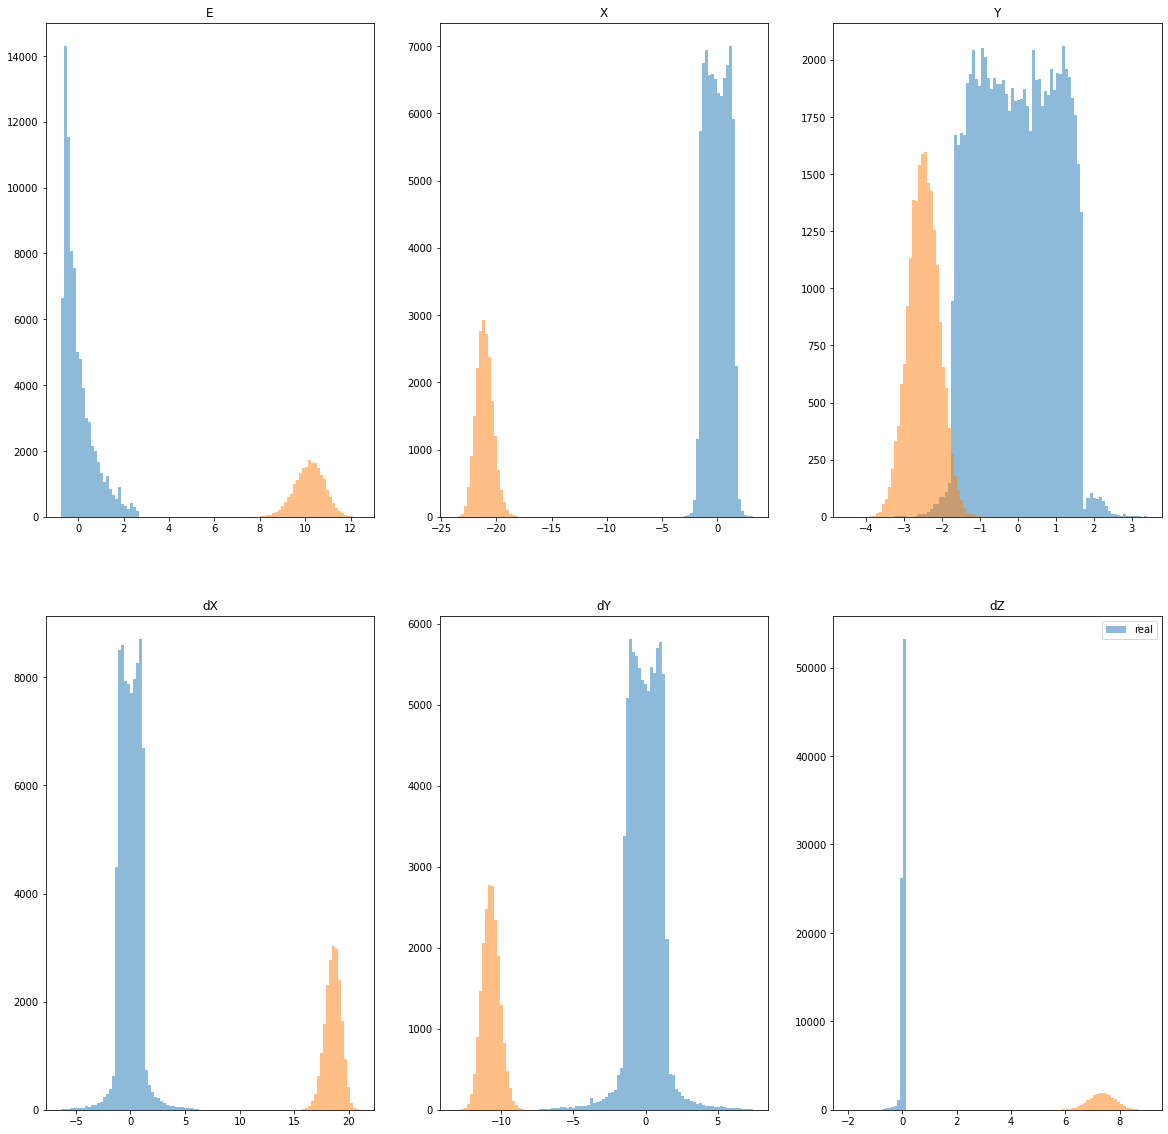

In [16]:
real = []
ds=generator.generator()
while len(real)*batch_size<b_size:
    real.append(next(ds))

real = np.array(real)
keys = ['E','X','Y','dX','dY','dZ']#['E','X','Y','angle1','angle2','dX','dY','dZ']

noise = torch.randn(b_size//4, nz, device=device)
# Generate fake image batch with G
fake = netG(noise).to(torch.device("cpu")).detach().numpy()

fig,axs = plt.subplots(2,3)
fig.set_size_inches(20,20)
for i, j in enumerate(keys):
    mi = np.minimum(real[0,:,i].min(),fake[:,i].min())
    ma = np.maximum(real[0,:,i].max(),fake[:,i].max())
    bins = np.linspace(mi,ma, 100)
    axs.flatten()[i].hist(real[0,:,i],bins,alpha=.5)
    axs.flatten()[i].hist(fake[:,i],bins,alpha=.5)
    axs.flatten()[i].set_title(j)
plt.legend(['real'])
plt.show()